### Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the libs

In [2]:
import os
import time
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
from tensorflow.python.client import device_lib

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

### Extracting the Dataset

In [3]:
filePath = '/content/drive/MyDrive/Datasets/GCScrapped/gc-dataset.zip'

In [4]:
!mkdir gcImages

In [5]:
!unzip /content/drive/MyDrive/Datasets/GCScrapped/gc-dataset.zip -d /content/gcImages

Streaming output truncated to the last 5000 lines.
  inflating: /content/gcImages/content/gc-dataset/train/5067.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/6851.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/3295.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/5518.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/7501.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/836.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/7283.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/2323.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/3291.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/5818.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/3408.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/6164.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/7634.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/2078.jpg  
  inflating:

### Global Var

In [6]:
dataset_path = '/content/gcImages/content/gc-dataset'
imgDirPath = '/content/gcImages/content/gc-dataset/train'
osSep = '/'
dataPath = imgDirPath + osSep + '*.jpg'

In [7]:
# image attr
img_w = 256
img_h = 256

#### Class to Clean the Dataset

In [8]:
class DatasetCleaner:
    
    '''
    Description : Class to Clean the Datasets
    '''

    # Method to remove the grayscale images from the directroy
    @staticmethod
    def removeGrayScaleFromDir(dirPath, osSep='/', fileType='*.jpg'):
        '''
        Description : 
                Method to remove any grayScale images from the directroy
        Input : 
                dirPath => Path to the image directory (dType - String)
                osSep => OS File Separator (dType - String | Defualt : backslash)
                fileType => Types of Images to read from the directory(dType - String | Default : '*.jpg') 	
        Returns : 
                List (Details of the files removed from the directory)
        '''

        print('Removing any grayScale Images from the directory.........')
        removedFileNames = []
        for id, fileName in enumerate(glob.glob(dirPath + osSep + fileType)):

            image = tf.io.read_file(fileName)
            image = tf.image.decode_jpeg(image)

            isGrayScale = True

            if len(image.shape) == 3 and image.shape[2] == 3:
                isGrayScale = False

            if isGrayScale:
                print(f'Removing ## ID : {id} ==== ImageShape : {image.shape} ==== FileName : {fileName}')
                removedFileNames.append([id, image.shape, fileName])
                os.remove(fileName)

        return removedFileNames

    # Method to remove the grayScale images from the numpy array
    @staticmethod
    def removeGrayScaleFromNumpy(numpyArr):
        '''
        Description : 
                Method to remove any grayScale images from the numpy.array
        Input : 
                numpyArr => numpy.array consisting of images
        Returns : 
                numpy.array (Consisting of only RGB images)
                List (Details of the images removed from the numpy)
        '''
        removedImages = []

        for id, image in enumerate(numpyArr):

            isGrayScale = True

            if len(image.shape) == 3 and image.shape[2] == 3:
                isGrayScale = False
            else:
                r = image[:,:,0]
                g = image[:,:,1]
                b = image[:,:,2]

                if r.all() == g.all() == b.all():
                    isGrayScale = True

            if isGrayScale:
                print(f'GrayScale Found ## ID : {id} ==== ImageShape : {image.shape}')
                removedImages.append([id, image.shape])

        print('Removing any grayScale Images from the numpy.array.........')
        numpyArr = np.delete(numpyArr, [dtl[0] for dtl in removedImages])

        return numpyArr, removedImages

### File Count of the gcDataset

In [9]:
total_files = len(glob.glob(imgDirPath + osSep + '*.jpg'))
print(f'Total JPG Files : {total_files}')

Total JPG Files : 8800


### Removing the any Grayscale Images from the dir

In [10]:
rmFileList = DatasetCleaner.removeGrayScaleFromDir(imgDirPath)
print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')
print(f'Total Count of the removed grayScale images : {len(rmFileList)}')    

Removing any grayScale Images from the directory.........
Removing ## ID : 119 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/4423.jpg
Removing ## ID : 911 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/8215.jpg
Removing ## ID : 1446 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/8679.jpg
Removing ## ID : 1530 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/4705.jpg
Removing ## ID : 1729 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/2661.jpg
Removing ## ID : 2145 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/8689.jpg
Removing ## ID : 2891 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/1204.jpg
Removing ## ID : 3056 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/co

In [11]:
total_files = len(glob.glob(imgDirPath + osSep + '*.jpg'))
print(f'Total JPG Files in the Directroy : {total_files}')

Total JPG Files in the Directroy : 8785


### Testing

In [12]:
filePaths = []
for files in glob.glob(dataPath):
    filePaths.append(files)
print('Added all the file paths')

Added all the file paths


In [13]:
print('Total No of Files in the array = {} '.format(len(filePaths)))

Total No of Files in the array = 8785 


#### Reading all the images and appeding to the imageData 

In [14]:
imageData = []
for itr, files in enumerate(filePaths):
    if itr % 100 == 0:
        print(f'Done Reading {itr + 1} Images')
    imageData.append(imread(files))
imageData = np.asarray(imageData)


Done Reading 1 Images
Done Reading 101 Images
Done Reading 201 Images
Done Reading 301 Images
Done Reading 401 Images
Done Reading 501 Images
Done Reading 601 Images
Done Reading 701 Images
Done Reading 801 Images
Done Reading 901 Images
Done Reading 1001 Images
Done Reading 1101 Images
Done Reading 1201 Images
Done Reading 1301 Images
Done Reading 1401 Images
Done Reading 1501 Images
Done Reading 1601 Images
Done Reading 1701 Images
Done Reading 1801 Images
Done Reading 1901 Images
Done Reading 2001 Images
Done Reading 2101 Images
Done Reading 2201 Images
Done Reading 2301 Images
Done Reading 2401 Images
Done Reading 2501 Images
Done Reading 2601 Images
Done Reading 2701 Images
Done Reading 2801 Images
Done Reading 2901 Images
Done Reading 3001 Images
Done Reading 3101 Images
Done Reading 3201 Images
Done Reading 3301 Images
Done Reading 3401 Images
Done Reading 3501 Images
Done Reading 3601 Images
Done Reading 3701 Images
Done Reading 3801 Images
Done Reading 3901 Images
Done Reading

In [15]:
print(f'Images in the np.array = {imageData.shape}')

Images in the np.array = (8785, 256, 256, 3)


In [16]:
imageData[0]

array([[[254, 252, 255],
        [254, 252, 255],
        [254, 252, 255],
        ...,
        [ 70,  73,  78],
        [140, 145, 149],
        [227, 232, 236]],

       [[254, 252, 255],
        [254, 252, 255],
        [254, 252, 255],
        ...,
        [115, 118, 123],
        [150, 155, 159],
        [248, 253, 255]],

       [[254, 252, 255],
        [254, 252, 255],
        [254, 252, 255],
        ...,
        [191, 196, 202],
        [156, 161, 167],
        [239, 244, 250]],

       ...,

       [[ 57,  46,  40],
        [ 40,  29,  23],
        [ 49,  38,  32],
        ...,
        [ 98,  81,  71],
        [ 92,  75,  65],
        [123, 106,  96]],

       [[ 54,  43,  37],
        [ 38,  27,  21],
        [ 32,  21,  15],
        ...,
        [ 82,  65,  55],
        [ 72,  55,  45],
        [101,  84,  74]],

       [[ 51,  40,  34],
        [ 64,  53,  47],
        [ 53,  42,  36],
        ...,
        [106,  89,  79],
        [ 77,  60,  50],
        [ 71,  54,  44]]

In [17]:
# Set up training and test data
split = int(0.95*len(imageData))
Xtrain = imageData[:split]

In [29]:
# creating the datagen

In [18]:
datagen = ImageDataGenerator(
    shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True
)

In [19]:
#Generate training data
batch_size = 20

In [20]:
def getXYBatch(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [21]:
#Design the neural network
model = Sequential()
model.add(Input(shape = (256,256,1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

# Finish model
model.compile(optimizer='rmsprop', loss='mse')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       1

In [ ]:
model.fit(getXYBatch(batch_size), epochs=1)

   3154/Unknown - 2335s 735ms/step - loss: 95.0793

In [16]:
x = imread(imgDirPath + osSep + '10.jpg')

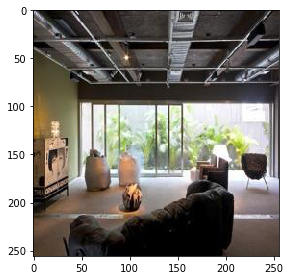

In [17]:
imshow(x)

In [19]:
print(rgb2lab(x).shape)

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


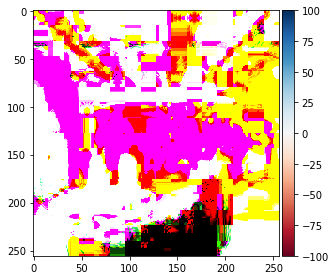

In [20]:
imshow(rgb2lab(x))

In [22]:
y = rgb2lab(x)

In [23]:
np.min(y[:,:,0])

0.0

In [25]:
np.min(y[:,:,1])

-35.786747111973824

In [26]:
np.min(y[:,:,2])

-17.275592506264424

In [27]:
np.max(y[:,:,0])

100.0

In [28]:
np.max(y[:,:,1])

28.47002863654574

In [29]:
np.max(y[:,:,2])

69.51537643629298